# Multi-Armed Bandit (MAB) Model Demonstration

This notebook demonstrates how to use different types of Multi-Armed Bandit (MAB) models in `causalml`:
1. Classic MAB models (EpsilonGreedy, UCB, ThompsonSampling)
2. Contextual MAB models (LinUCB)
3. Batch-mode Classic MAB models (using BatchBandit wrapper)
4. Batch-mode Contextual MAB models (BatchLinUCB)

Each section will show a simple, streamlined example of how to use these models without additional function wrappers.

## 1. Setup and Imports

First, let's import all the necessary libraries and set up our environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causalml.dataset import make_mab_data
from causalml.optimize.bandit import (
    # Classic MAB models
    EpsilonGreedy, UCB, ThompsonSampling,
    # Contextual MAB models
    LinUCB,
    # Batch processing wrapper
    BatchBandit
)

# Set random seed for reproducibility
np.random.seed(42)

## 2. Data Generation

We'll generate synthetic data for our bandit experiments using `make_mab_data`. This function creates a dataset with:
- Multiple arms
- Features that influence rewards
- Different reward rates for each arm

In [2]:
# Data generation configuration
n_samples = 10000
n_arms = 4
n_features = 3
n_informative = 2
n_redundant = 1
n_repeated = 0
arm_effects = {
    'arm_0': 0.0,    # Control arm
    'arm_1': -0.01,  # Small negative effect
    'arm_2': -0.02,  # Medium negative effect
    'arm_3': -0.04   # Large negative effect
}
positive_class_proportion = 0.1
random_seed = 42
feature_association_list = ["linear", "quadratic"]
random_select_association = False
error_std = 0.05
n_arm_features = {'arm_0': 0, 'arm_1': 1, 'arm_2': 0, 'arm_3': 0}  # Updated to include all arms
n_mixed_features = {'arm_1': 0, 'arm_2': 0, 'arm_3': 0}

# Generate data
df, feature_names = make_mab_data(
    n_samples=n_samples,
    n_arms=n_arms,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_repeated=n_repeated,
    arm_effects=arm_effects,
    positive_class_proportion=positive_class_proportion,
    random_seed=random_seed,
    feature_association_list=feature_association_list,
    random_select_association=random_select_association,
    error_std=error_std,
    n_arm_features=n_arm_features,
    n_mixed_features=n_mixed_features
)

# Extract features, arms, and rewards
X = df[feature_names].values
arms = df['arm'].values
rewards = df['reward'].values

## 3. Classic MAB Models

Let's demonstrate how to use classic MAB models (EpsilonGreedy, UCB, ThompsonSampling).
These models don't use contextual information and make decisions based on historical rewards only.

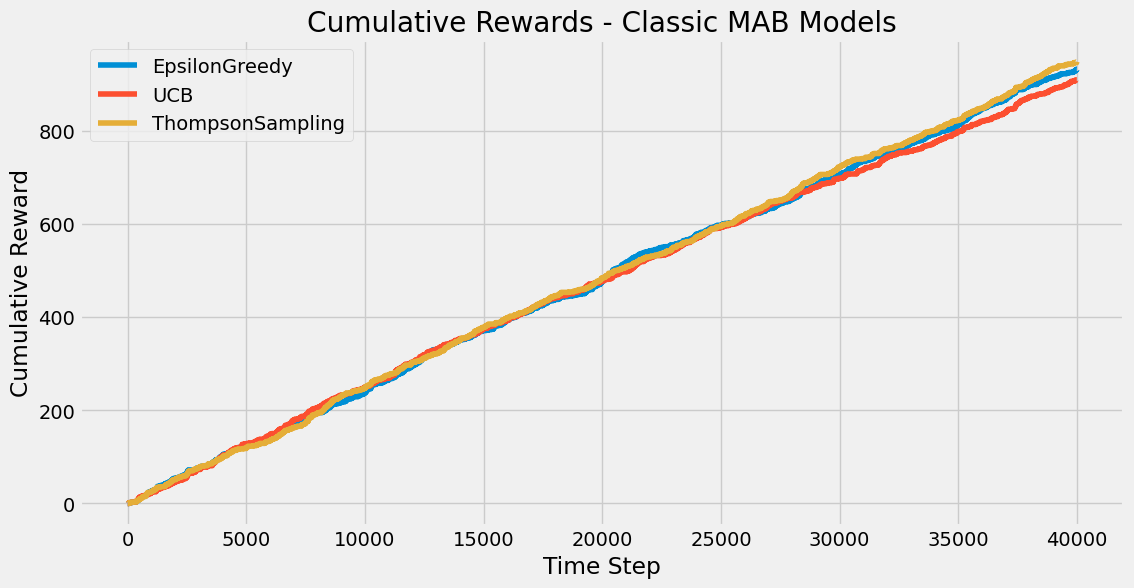

In [3]:
# Initialize classic MAB models
eg = EpsilonGreedy(epsilon=0.1)
ucb = UCB()
ts = ThompsonSampling()

# Fit the models with initial data
eg.fit(arms, rewards)
ucb.fit(arms, rewards)
ts.fit(arms, rewards)

# Run online evaluation
eg_rewards = []
ucb_rewards = []
ts_rewards = []

eg_arms = []
ucb_arms = []
ts_arms = []

for i in range(len(X)):
    # EpsilonGreedy
    chosen_arm = eg.select_arm()
    reward = rewards[i] if chosen_arm == arms[i] else 0
    eg.update(chosen_arm, reward)
    eg_rewards.append(reward)
    eg_arms.append(chosen_arm)
    
    # UCB
    chosen_arm = ucb.select_arm()
    reward = rewards[i] if chosen_arm == arms[i] else 0
    ucb.update(chosen_arm, reward)
    ucb_rewards.append(reward)
    ucb_arms.append(chosen_arm)
    
    # ThompsonSampling
    chosen_arm = ts.select_arm()
    reward = rewards[i] if chosen_arm == arms[i] else 0
    ts.update(chosen_arm, reward)
    ts_rewards.append(reward)
    ts_arms.append(chosen_arm)

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(eg_rewards), label='EpsilonGreedy')
plt.plot(np.cumsum(ucb_rewards), label='UCB')
plt.plot(np.cumsum(ts_rewards), label='ThompsonSampling')
plt.title('Cumulative Rewards - Classic MAB Models')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

## 4. Contextual MAB Models

Now let's demonstrate how to use contextual MAB models (LinUCB).
These models use feature information to make decisions.

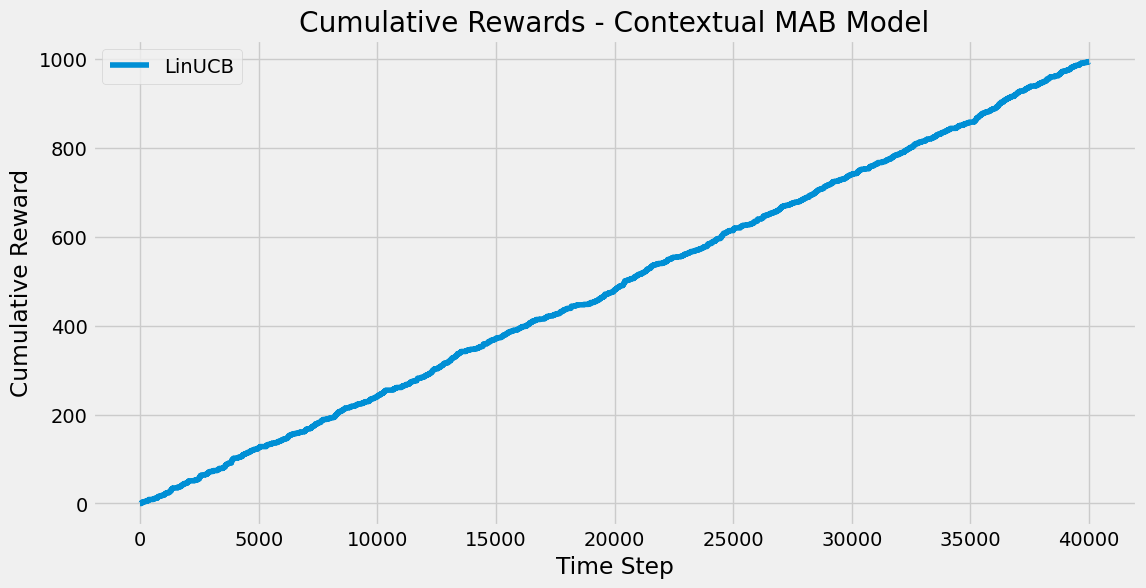

In [4]:
# Initialize contextual MAB model
linucb = LinUCB(alpha=1.0)
linucb.fit(X=pd.DataFrame(X, columns=feature_names), arm=arms, reward=rewards, features=feature_names)

# Run online evaluation
linucb_rewards = []
linucb_arms = []

for i in range(len(X)):
    # LinUCB
    chosen_arm = linucb.select_arm(X[i])
    reward = rewards[i] if chosen_arm == arms[i] else 0
    linucb.update(chosen_arm, X[i], reward)
    linucb_rewards.append(reward)
    linucb_arms.append(chosen_arm)

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(linucb_rewards), label='LinUCB')
plt.title('Cumulative Rewards - Contextual MAB Model')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

## 5. Batch-mode Classic MAB Models

Let's demonstrate how to use batch-mode classic MAB models using the BatchBandit wrapper.
These models process data in batches rather than one sample at a time.

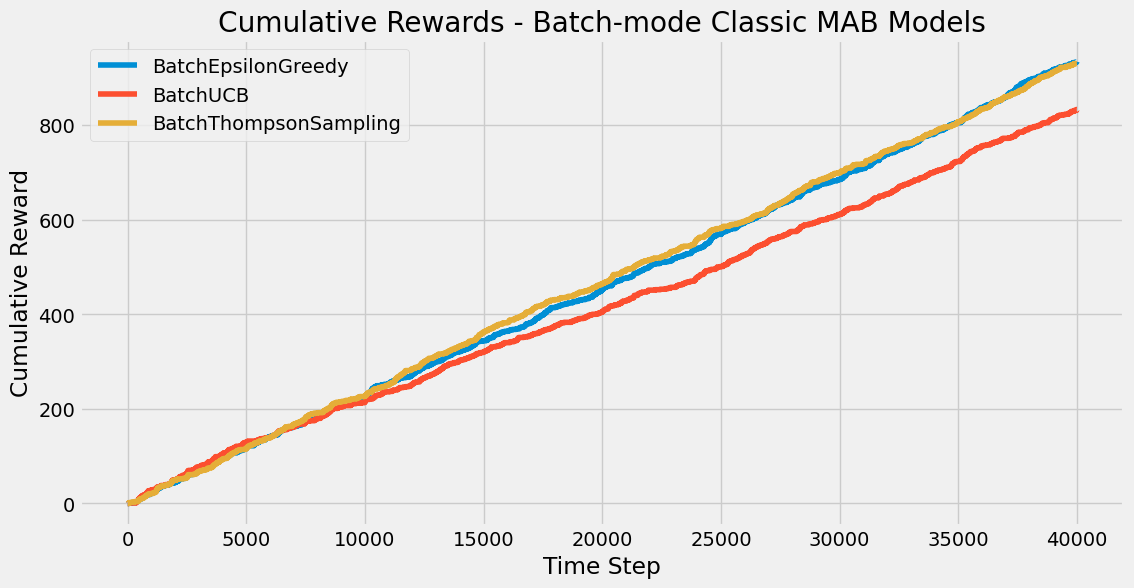

In [5]:
# Initialize batch-mode classic MAB models
batch_size = 100
beg = BatchBandit(EpsilonGreedy(epsilon=0.1), batch_size=batch_size)
beg.bandit.fit(arms, rewards)
bucb = BatchBandit(UCB(), batch_size=batch_size)
bucb.bandit.fit(arms, rewards)
bts = BatchBandit(ThompsonSampling(), batch_size=batch_size)
bts.bandit.fit(arms, rewards)

# Run batch evaluation
beg_rewards = []
bucb_rewards = []
bts_rewards = []

beg_arms = []
bucb_arms = []
bts_arms = []

for i in range(0, len(X), batch_size):
    batch_X = X[i:i + batch_size]
    batch_arms = arms[i:i + batch_size]
    batch_rewards = rewards[i:i + batch_size]
    
    # BatchEpsilonGreedy
    chosen_arms = beg.select_batch()
    rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
    beg.update_batch(chosen_arms, rewards_batch)
    beg_rewards.extend(rewards_batch)
    beg_arms.extend(chosen_arms)
    
    # BatchUCB
    chosen_arms = bucb.select_batch()
    rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
    bucb.update_batch(chosen_arms, rewards_batch)
    bucb_rewards.extend(rewards_batch)
    bucb_arms.extend(chosen_arms)
    
    # BatchThompsonSampling
    chosen_arms = bts.select_batch()
    rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
    bts.update_batch(chosen_arms, rewards_batch)
    bts_rewards.extend(rewards_batch)
    bts_arms.extend(chosen_arms)

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(beg_rewards), label='BatchEpsilonGreedy')
plt.plot(np.cumsum(bucb_rewards), label='BatchUCB')
plt.plot(np.cumsum(bts_rewards), label='BatchThompsonSampling')
plt.title('Cumulative Rewards - Batch-mode Classic MAB Models')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

## 6. Batch-mode Contextual MAB Models

Finally, let's demonstrate how to use batch-mode contextual MAB models.
These models combine batch processing with contextual information.

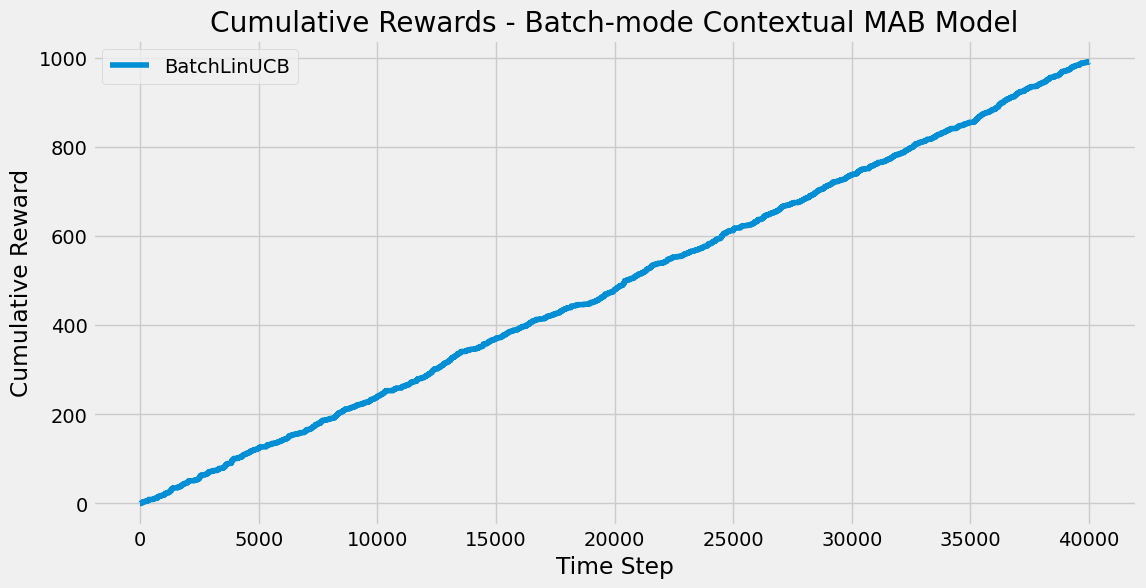

In [6]:
# Initialize batch-mode contextual MAB model
blinucb = BatchBandit(LinUCB(alpha=1.0), batch_size=batch_size)
blinucb.bandit.fit(X=pd.DataFrame(X, columns=feature_names), arm=arms, reward=rewards, features=feature_names)

# Run batch evaluation
blinucb_rewards = []
blinucb_arms = []

for i in range(0, len(X), batch_size):
    batch_X = X[i:i + batch_size]
    batch_arms = arms[i:i + batch_size]
    batch_rewards = rewards[i:i + batch_size]
    
    # BatchLinUCB - process each sample in the batch individually since we need context
    chosen_arms = []
    rewards_batch = []
    for context in batch_X:
        chosen_arm = blinucb.bandit.select_arm(context)
        chosen_arms.append(chosen_arm)
    
    rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
    for chosen_arm, context, reward in zip(chosen_arms, batch_X, rewards_batch):
        blinucb.bandit.update(chosen_arm, context, reward)
    
    blinucb_rewards.extend(rewards_batch)
    blinucb_arms.extend(chosen_arms)

# Plot cumulative rewards
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(blinucb_rewards), label='BatchLinUCB')
plt.title('Cumulative Rewards - Batch-mode Contextual MAB Model')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

## 7. Compare All Models

Let's compare the performance of all models by plotting their cumulative rewards together.

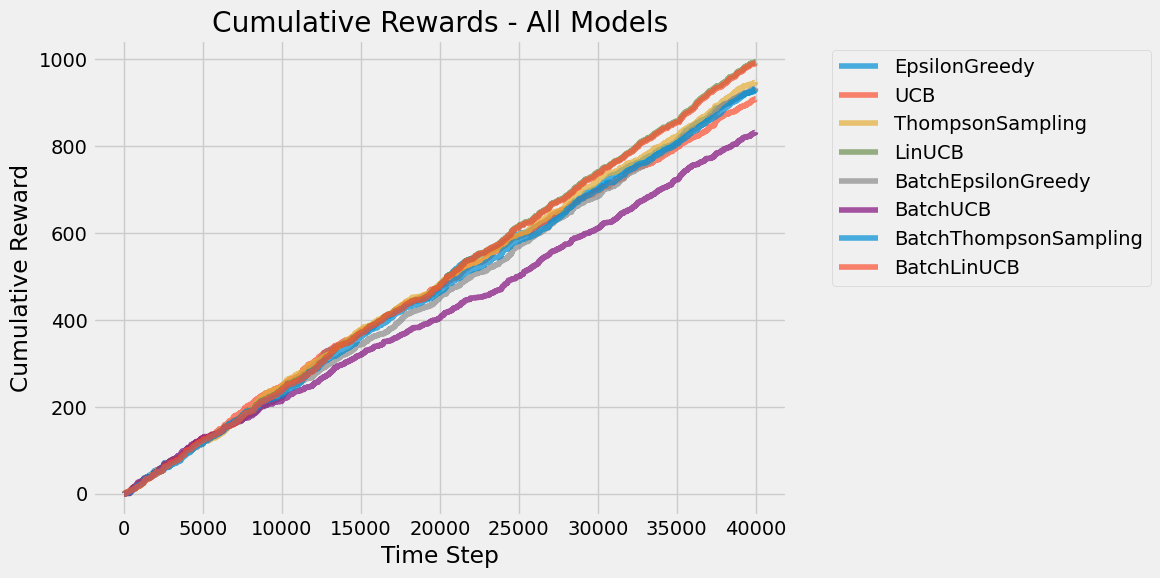

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(eg_rewards), label='EpsilonGreedy', alpha=0.7)
plt.plot(np.cumsum(ucb_rewards), label='UCB', alpha=0.7)
plt.plot(np.cumsum(ts_rewards), label='ThompsonSampling', alpha=0.7)
plt.plot(np.cumsum(linucb_rewards), label='LinUCB', alpha=0.7)
plt.plot(np.cumsum(beg_rewards), label='BatchEpsilonGreedy', alpha=0.7)
plt.plot(np.cumsum(bucb_rewards), label='BatchUCB', alpha=0.7)
plt.plot(np.cumsum(bts_rewards), label='BatchThompsonSampling', alpha=0.7)
plt.plot(np.cumsum(blinucb_rewards), label='BatchLinUCB', alpha=0.7)
plt.title('Cumulative Rewards - All Models')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Arm Selection Analysis

Let's analyze how each model distributes its arm selections.

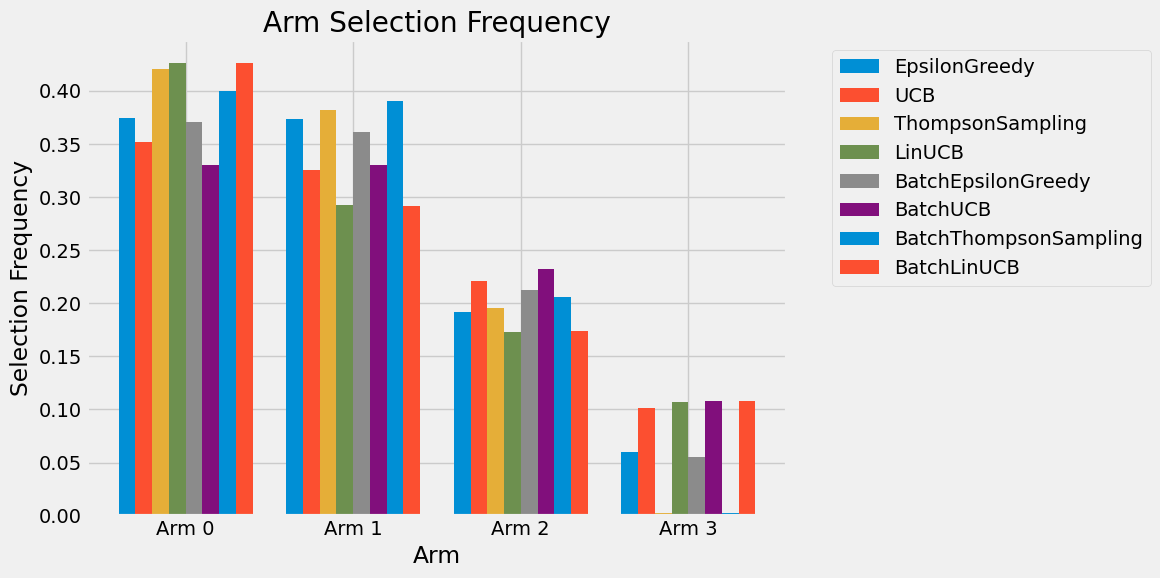

In [8]:
# Calculate arm selection frequencies
def get_arm_frequencies(selected_arms):
    return pd.Series(selected_arms).value_counts(normalize=True)

# Plot arm selection frequencies
plt.figure(figsize=(12, 6))
n_methods = 8
bar_width = 0.8 / n_methods
x = np.arange(n_arms)

methods = [
    ('EpsilonGreedy', eg_arms),
    ('UCB', ucb_arms),
    ('ThompsonSampling', ts_arms),
    ('LinUCB', linucb_arms),
    ('BatchEpsilonGreedy', beg_arms),
    ('BatchUCB', bucb_arms),
    ('BatchThompsonSampling', bts_arms),
    ('BatchLinUCB', blinucb_arms)
]

for i, (name, arms) in enumerate(methods):
    arm_freq = get_arm_frequencies(arms)
    plt.bar(x + i * bar_width, arm_freq.values, width=bar_width, label=name)

plt.title('Arm Selection Frequency')
plt.xlabel('Arm')
plt.ylabel('Selection Frequency')
plt.xticks(x + bar_width * (n_methods - 1) / 2, [f'Arm {i}' for i in range(n_arms)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show() 